In [77]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

IMAGES_PATH = Path('./UCMerced_LandUse/Images')

### Calculate sift descriptors for all images

In [78]:
sift = cv2.SIFT_create(contrastThreshold=0.055)


def dataloader(path):
    for image_file in path.rglob('*.tif'):
        img = cv2.imread(str(image_file), 1)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, descriptors = sift.detectAndCompute(img, None)
        yield str(image_file), descriptors


def compute_all_descriptors():
    descriptors_list = []
    idx_to_file_path = {}
    with tqdm(total=2100, position=0, leave=True) as program_bar:
        for idx, (file_path, descriptors) in enumerate(dataloader(IMAGES_PATH)):
            descriptors_list.append(descriptors)
            idx_to_file_path[idx] = file_path
            program_bar.update()
    return descriptors_list, idx_to_file_path
    # descriptors: [descriptors_of_img1, descriptors_of_img2,...]
    # idx_to_file_path: {0:'1.tif', 1:'2.tif',...}


descriptors_list, idx_to_file = compute_all_descriptors()
all_descriptors = tuple(des for des in descriptors_list if des is not None)
all_descriptors = np.concatenate(all_descriptors, dtype=np.float32)
print(all_descriptors.shape)

100%|██████████| 2100/2100 [00:48<00:00, 43.53it/s]


(1132081, 128)


### Define HI kernel

In [79]:
def hi_kernel(x, y):
    return np.minimum(x, y).sum()


a, b = np.array([[1, 2, 3]]), np.array([[0, 5, 0]])
hi_kernel(a, b)


2

### Calculate codebook of BOVW

In [80]:
from sklearn.cluster import MiniBatchKMeans
import time

N_CLUSTERS = 150
SAMPLED_SIZE = 100000

sampled_descriptors = all_descriptors[np.random.choice(all_descriptors.shape[0], SAMPLED_SIZE, replace=False)]


def creat_codebook(sampled_descriptors):
    start = time.time()
    kmeans = MiniBatchKMeans(n_clusters=N_CLUSTERS, verbose=True, batch_size=10000)
    kmeans.fit(sampled_descriptors)
    kmeans.verbose = False
    print(time.time() - start)
    return kmeans


codebook = creat_codebook(sampled_descriptors)

Init 1/3 with method: k-means++
Inertia for init 1/3: 2471402752.000000
Init 2/3 with method: k-means++
Inertia for init 2/3: 2477778944.000000
Init 3/3 with method: k-means++
Inertia for init 3/3: 2484167424.000000
Minibatch iteration 1/1000: mean batch inertia: 82961.696000, ewa inertia: 82961.696000 
Minibatch iteration 2/1000: mean batch inertia: 82779.942400, ewa inertia: 82925.345644 
Minibatch iteration 3/1000: mean batch inertia: 81644.652800, ewa inertia: 82669.209636 
Minibatch iteration 4/1000: mean batch inertia: 82092.832000, ewa inertia: 82553.935262 
Minibatch iteration 5/1000: mean batch inertia: 81440.499200, ewa inertia: 82331.250276 
Minibatch iteration 6/1000: mean batch inertia: 81898.969600, ewa inertia: 82244.795006 
Minibatch iteration 7/1000: mean batch inertia: 81254.156800, ewa inertia: 82046.669346 
Minibatch iteration 8/1000: mean batch inertia: 81644.006400, ewa inertia: 81966.137562 
Minibatch iteration 9/1000: mean batch inertia: 81005.350400, ewa inerti

### Create BOVW

In [81]:
from sklearn.preprocessing import normalize

BOVW_NORM = 'l2'


def descriptors_to_bovw(descriptors, codebook):
    _bovw = np.zeros(N_CLUSTERS)
    if descriptors is not None:
        for idx in codebook.predict(descriptors):
            _bovw[idx] += 1
        _bovw = normalize(_bovw[np.newaxis, :], norm=BOVW_NORM).ravel()
    else:
        _bovw += (1 / N_CLUSTERS)
    return _bovw


def compute_bovws(descriptors_list):
    bovws = []
    with tqdm(total=2100, position=0, leave=True) as program_bar:
        for descriptors in descriptors_list:
            bovw = descriptors_to_bovw(descriptors, codebook)
            bovws.append(bovw)
            program_bar.update()
    return np.stack(bovws)


bovws = compute_bovws(descriptors_list)

100%|██████████| 2100/2100 [00:03<00:00, 572.90it/s]


### Init training dataset

In [82]:
import random

INIT_RELEVANT, INIT_IRRELEVANT = 2 + 1, 3
TRAINING_CLASS = 'agricultural'


def init_train_set(class_name):
    relevant = [k for k, v in idx_to_file.items() if class_name in v]
    irrlevant = [k for k, v in idx_to_file.items() if class_name not in v]
    labels = [1] * INIT_RELEVANT + [0] * INIT_IRRELEVANT
    return random.sample(relevant, k=INIT_RELEVANT) + random.sample(irrlevant, k=INIT_IRRELEVANT), labels


init_train_set(TRAINING_CLASS)

([33, 55, 81, 1667, 1203, 2074], [1, 1, 1, 0, 0, 0])

### Create HI kernel matrix and train svm

In [83]:
from sklearn import svm


def hi_kernel_matrix(x, y):
    matrix = np.zeros((x.shape[0], y.shape[0]), dtype=np.float32)
    for i in range(x.shape[0]):
        for j in range(y.shape[0]):
            matrix[i][j] = hi_kernel(x[i], y[j])
    return matrix


def train_svm(dataset):
    clf = svm.SVC(kernel=hi_kernel_matrix)
    train_data = bovws[dataset[0]]
    labels = dataset[1]
    clf.fit(train_data, labels)
    return clf


dataset = init_train_set(TRAINING_CLASS)
clf = train_svm(dataset)

### Visualize the most uncertain and certain samples

In [84]:
def draw_imgs(img, rows, cols, cnt, title='', color='k'):
    plt.subplot(rows, cols, cnt)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(title, color=color)


def show_img_idx(idx_list):
    plt.figure(figsize=(2 * len(idx_list), 2), dpi=72)
    for idx, img_idx in enumerate(idx_list, start=1):
        img_path = idx_to_file[img_idx]
        img = cv2.imread(idx_to_file[img_idx], 1)
        draw_imgs(img, 1, len(idx_list), idx, Path(img_path).parts[-2])
    plt.show()

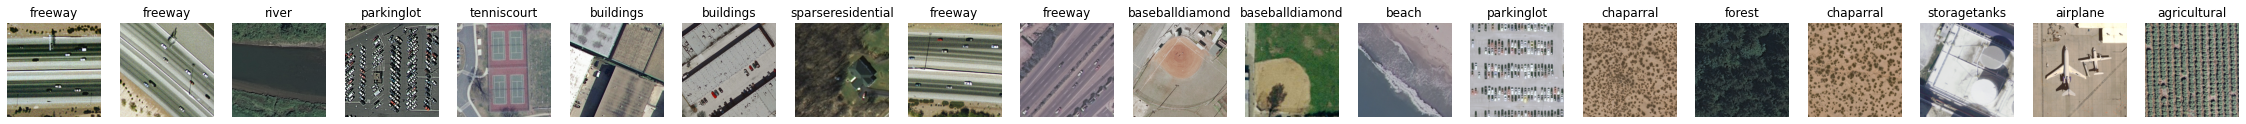

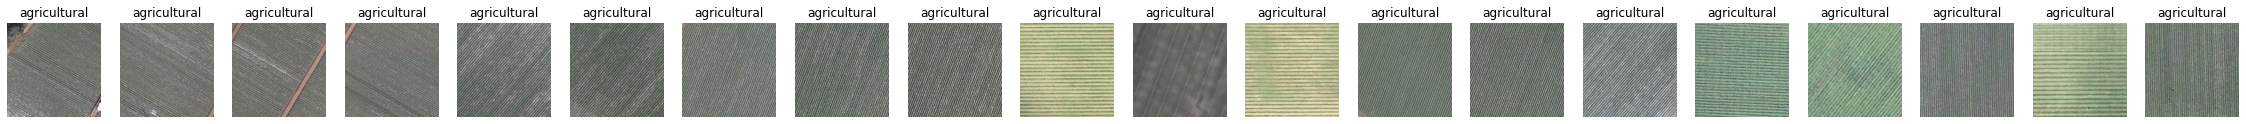

In [85]:
H = 5
M = 4 * H


def margin_sampling(clf, topk):
    distance = np.abs(clf.decision_function(bovws))
    return np.argsort(distance)[:topk]


s_uncertain_idx = margin_sampling(clf, M)
show_img_idx(s_uncertain_idx)
show_img_idx(np.argwhere(clf.decision_function(bovws) > 0)[:, 0][:M])

### Kernel K-means clustering and Visualize each cluster

In [86]:
"""Kernel K-means"""

# Author: Mathieu Blondel <mathieu@mblondel.org>
# License: BSD 3 clause

import numpy as np

from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.utils import check_random_state


class KernelKMeans(BaseEstimator, ClusterMixin):
    """
    Kernel K-means

    Reference
    ---------
    Kernel k-means, Spectral Clustering and Normalized Cuts.
    Inderjit S. Dhillon, Yuqiang Guan, Brian Kulis.
    KDD 2004.
    """

    def __init__(self, n_clusters=3, max_iter=50, tol=1e-3, random_state=None,
                 kernel="linear", gamma=None, degree=3, coef0=1,
                 kernel_params=None, verbose=0):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.coef0 = coef0
        self.kernel_params = kernel_params
        self.verbose = verbose

    @property
    def _pairwise(self):
        return self.kernel == "precomputed"

    def _get_kernel(self, X, Y=None):
        if callable(self.kernel):
            params = self.kernel_params or {}
        else:
            params = {"gamma": self.gamma,
                      "degree": self.degree,
                      "coef0": self.coef0}
        return pairwise_kernels(X, Y, metric=self.kernel,
                                filter_params=True, **params)

    def fit(self, X, y=None, sample_weight=None):
        n_samples = X.shape[0]

        K = self._get_kernel(X)

        sw = sample_weight if sample_weight else np.ones(n_samples)
        self.sample_weight_ = sw

        rs = check_random_state(self.random_state)
        self.labels_ = rs.randint(self.n_clusters, size=n_samples)

        dist = np.zeros((n_samples, self.n_clusters))
        self.within_distances_ = np.zeros(self.n_clusters)

        for it in range(self.max_iter):
            dist.fill(0)
            try:
                self._compute_dist(K, dist, self.within_distances_,
                                   update_within=True)
            except ValueError:
                self.fit(X, sample_weight)
                break
            labels_old = self.labels_
            self.labels_ = dist.argmin(axis=1)

            # Compute the number of samples whose cluster_ did not change
            # since last iteration.
            n_same = np.sum((self.labels_ - labels_old) == 0)
            if 1 - float(n_same) / n_samples < self.tol:
                if self.verbose:
                    print("Converged at iteration", it + 1)
                break

        self.X_fit_ = X

        return self

    def _compute_dist(self, K, dist, within_distances, update_within):
        """Compute a n_samples x n_clusters distance matrix using the
        kernel trick."""
        sw = self.sample_weight_

        for j in range(self.n_clusters):
            mask = self.labels_ == j

            if np.sum(mask) == 0:
                raise ValueError("Empty cluster_ found, try smaller n_cluster.")

            denom = sw[mask].sum()
            denomsq = denom * denom

            if update_within:
                KK = K[mask][:, mask]  # K[mask, mask] does not work.
                dist_j = np.sum(np.outer(sw[mask], sw[mask]) * KK / denomsq)
                within_distances[j] = dist_j
                dist[:, j] += dist_j
            else:
                dist[:, j] += within_distances[j]

            dist[:, j] -= 2 * np.sum(sw[mask] * K[:, mask], axis=1) / denom

    def predict(self, X):
        K = self._get_kernel(X, self.X_fit_)
        n_samples = X.shape[0]
        dist = np.zeros((n_samples, self.n_clusters))
        self._compute_dist(K, dist, self.within_distances_,
                           update_within=False)
        return dist.argmin(axis=1)

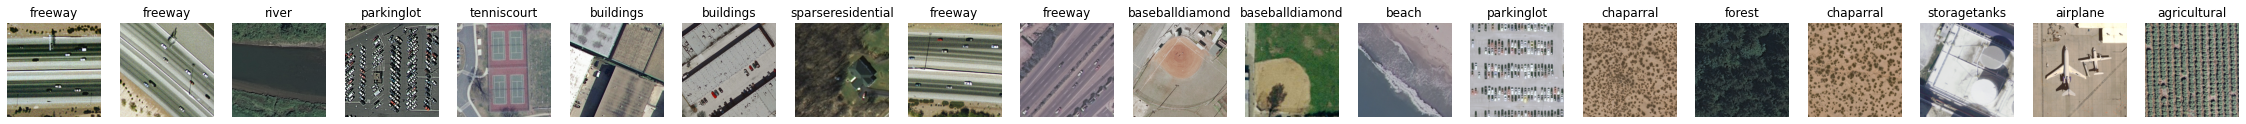

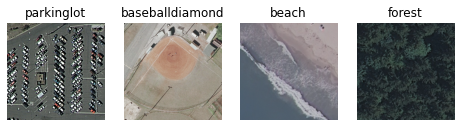

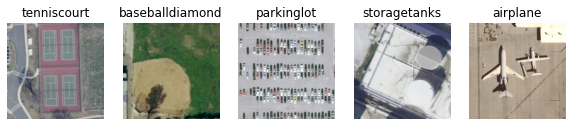

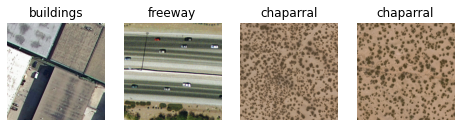

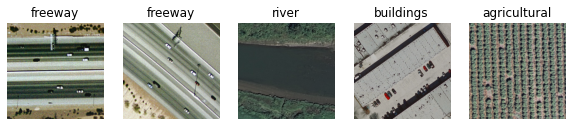

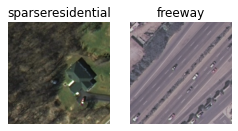

In [87]:
def _kernel_kmeans_clustering(s_uncertain_idx):
    kmeans = KernelKMeans(n_clusters=H, kernel=hi_kernel)
    kmeans.fit(bovws[s_uncertain_idx])
    clusting_result = kmeans.predict(bovws[s_uncertain_idx])
    all_clusters_idx = []
    for cluster_num in range(H):
        all_clusters_idx.append(
            np.array([s_uncertain_idx[idx] for idx in range(M) if clusting_result[idx] == cluster_num]))
    return all_clusters_idx


show_img_idx(s_uncertain_idx)
for cluster in _kernel_kmeans_clustering(s_uncertain_idx):
    show_img_idx(cluster)

### Estimate the cluster densities and select the most representative sample of each cluster

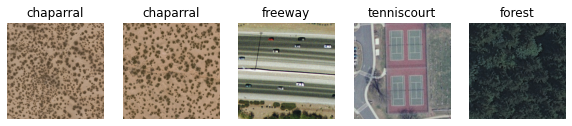

In [88]:
def _compute_density(cluster_):
    """compute the density of one cluster"""
    kernel_matrix = hi_kernel_matrix(cluster_, cluster_)
    x_density = []
    for i in range(cluster_.shape[0]):
        distance = 0
        for j in range(cluster_.shape[0]):
            distance += kernel_matrix[i][i]
            distance += kernel_matrix[j][j]
            distance -= 2 * kernel_matrix[i][j]
        x_density.append(distance)
    return x_density


def select_most_repersent(s_uncertain_idx_):
    all_clusters_idx = _kernel_kmeans_clustering(s_uncertain_idx_)
    x_most_represent = []
    for cluster_idx in all_clusters_idx:
        x_density = _compute_density(bovws[cluster_idx])
        x_most_represent.append(cluster_idx[x_density.index(max(x_density))])
    return x_most_represent


show_img_idx(select_most_repersent(s_uncertain_idx))

### Annotate the most represent samples

In [89]:
def update_dataset(dataset, x_most_represent, real_class_name):
    for idx in x_most_represent:
        dataset[0].append(idx)
        if real_class_name in idx_to_file[idx]:
            dataset[1].append(1)
        else:
            dataset[1].append(0)

### Retrieve demo

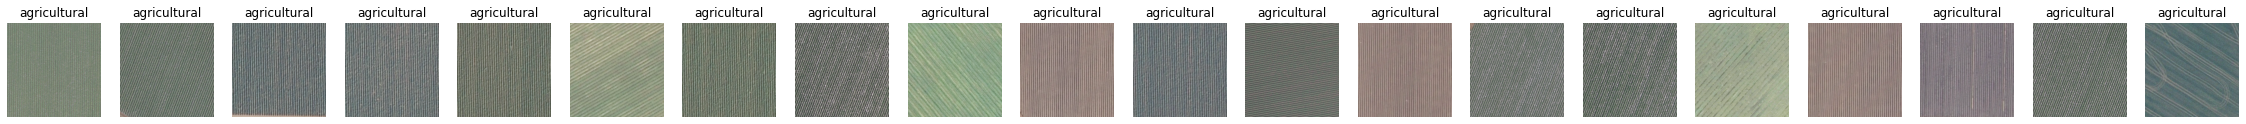

In [90]:
def retrieve(clf, topk):
    retrieved = np.argsort(clf.decision_function(bovws)).tolist()
    for idx in dataset[0]:
        if idx in retrieved:
            retrieved.remove(idx)
    return np.array(retrieved[-topk:])


show_img_idx(retrieve(clf, 20))

### Train svm by TCAL and plot the precision in each relevance feedback iteration

In [91]:
def test(clf, topk, real_class_name):
    retrieved_idx = retrieve(clf, topk)
    correct = 0
    for img_idx in retrieved_idx:
        correct += 1 if real_class_name in idx_to_file[img_idx] else 0
    return correct / topk


test(clf, 20, TRAINING_CLASS)

1.0

In [92]:
def train(dataset, real_class_name):
    clf = train_svm(dataset)
    s_uncertain_idx = margin_sampling(clf, M)
    x_most_represent = select_most_repersent(s_uncertain_idx)
    update_dataset(dataset, x_most_represent, real_class_name)
    return clf

100%|██████████| 30/30 [03:36<00:00,  7.22s/it]

[0.835      0.865      0.87666667 0.92166667 0.905      0.95166667
 0.96       0.97       0.97       0.98      ]


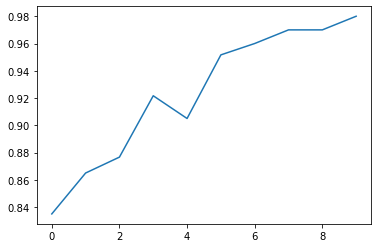

In [93]:
all_result = np.zeros(10)
for trials in tqdm(range(30)):
    one_result = np.zeros(10)
    class_name = 'forest'
    dataset = init_train_set(class_name)
    for i in range(10):
        clf = train(dataset, class_name)
        one_result[i] = test(clf, 20, class_name)
    all_result += one_result
all_result /= 30
print(all_result)
plt.plot(all_result)

### Test the precision of all categories

100%|██████████| 21/21 [48:37<00:00, 138.93s/it]


<BarContainer object of 21 artists>

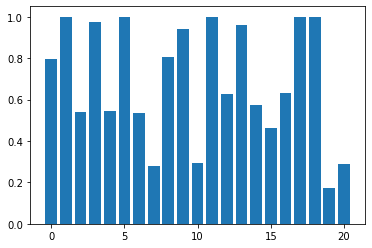

In [94]:
result = np.zeros(21)
for idx, class_name in tqdm(
        enumerate(['beach', 'agricultural', 'buildings', 'forest', 'river', 'harbor', 'denseresidential',
                   'sparseresidential', 'freeway', 'airplane', 'baseballdiamond', 'chaparral', 'golfcourse',
                   'mobilehomepark', 'intersection', 'mediumresidential', 'overpass', 'parkinglot', 'runway',
                   'storagetanks', 'tenniscourt']), total=21):
    for _ in range(30):
        dataset = init_train_set(class_name)
        for i in range(11):
            clf = train(dataset, class_name)
        result[idx] += test(clf, 20, class_name)
result /= 30
plt.bar(np.arange(21), result)

In [95]:
print(result.sum() / len(result))

0.6869047619047619
